In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import astropy.units as u
import numpy as np
from aos_scheduler import almanac, PeekSky, Block, schedule_blocks
from astropy.utils.masked import Masked

peekSky = PeekSky()

In [3]:
# Use almanac to find 12-degree sunset
night1 = almanac("2024-06-25", verbose=True)

   alt      America/Santiago                     UTC                      PT

sunset
     0   2024-06-25 17:47:31     2024-06-25 21:47:31     2024-06-25 14:47:31
    -6   2024-06-25 18:18:17     2024-06-25 22:18:17     2024-06-25 15:18:17
   -12   2024-06-25 18:48:14     2024-06-25 22:48:14     2024-06-25 15:48:14
   -18   2024-06-25 19:17:33     2024-06-25 23:17:33     2024-06-25 16:17:33

sunrise
     0   2024-06-26 07:44:15     2024-06-26 11:44:15     2024-06-26 04:44:15
    -6   2024-06-26 07:13:29     2024-06-26 11:13:29     2024-06-26 04:13:29
   -12   2024-06-26 06:43:33     2024-06-26 10:43:33     2024-06-26 03:43:33
   -18   2024-06-26 06:14:14     2024-06-26 10:14:14     2024-06-26 03:14:14

moonrise
     0   2024-06-25 21:55:18     2024-06-26 01:55:18     2024-06-25 18:55:18

moonset
     0   2024-06-26 11:19:58     2024-06-26 15:19:58     2024-06-26 08:19:58


(<Figure size 600x500 with 1 Axes>, <Axes: >)

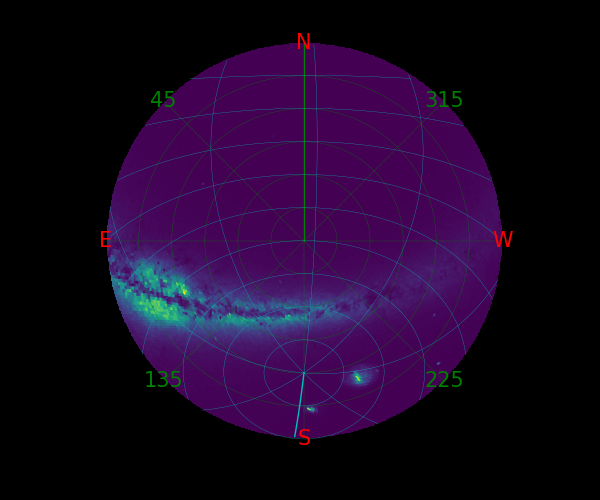

In [4]:
# Take a look at the sky near 12-degree twilight
peekSky.peek_sky(night1['sunset'][-12])

In [5]:
# We're pretty clear, especially in the north.  Let's target az~0 and alt~75

In [6]:
# Start with camera sweeps in dz, dx and dy.
# Set the rotator (rotTelPos) to 0.0 degrees.

# We want to track the sky in between exposures, which means the alt/az/rtp will
# change.  Let the AOS schedule planner handle this by masking the alt/az/rtp
# values after the first one.

# For the camera dz sweep, we have the option of either manipulating
# focusZ or cam_shift_dz.  We'll use cam_shift_dz here where the goal
# is to measure small changes in spot size, and use focusZ for large
# shifts intended to create intra/extra donuts for wavefront analysis.

# Dict to hold all blocks.  Recall dicts are ordered in Python 3.7+.
night1_blocks = {}

nobs = 9
mask = [False]+[True]*(nobs-1)  # Set alt/az/rtp in first obs, then track afterwards.
alt = Masked([75.0]*nobs*u.deg, mask=mask)
az = Masked([9.0]*nobs*u.deg, mask=mask)  # Will end up tracking from ~9 to -9 degrees
rtp = Masked([0.0]*nobs*u.deg, mask=mask)
cam_shift_dz = np.linspace(-150, 150, nobs)*u.micron

night1_blocks['sweep_cam_dz'] = Block(
    az=az,
    alt=alt,
    rtp=rtp,
    cam_shift_dz=cam_shift_dz,
    n=nobs,
    name="sweep_cam_dz"
)
night1_blocks['sweep_cam_dz']._table.pprint_all()

# Continue tracking for dx, dy sweeps. Set mask to True for all.
mask = [True]*nobs
alt = Masked([np.nan]*nobs*u.deg, mask=mask)
az = Masked([np.nan]*nobs*u.deg, mask=mask)
rtp = Masked([np.nan]*nobs*u.deg, mask=mask)
cam_shift_dx = np.linspace(-7000, 7000, nobs)*u.micron
night1_blocks['sweep_cam_dx'] = Block(
    az=az,
    alt=alt,
    rtp=rtp,
    cam_shift_dx=cam_shift_dx,
    n=nobs,
    name="sweep_cam_dx"
)
cam_shift_dy = np.linspace(-7000, 7000, nobs)*u.micron
night1_blocks['sweep_cam_dy'] = Block(
    az=az,
    alt=alt,
    rtp=rtp,
    cam_shift_dy=cam_shift_dy,
    n=nobs,
    name="sweep_cam_dy"
)
night1_blocks['sweep_cam_dx']._table.pprint_all()
night1_blocks['sweep_cam_dy']._table.pprint_all()

 block_name  band exptime elaptime focusZ m2_shift [dz, dx, dy] m2_rot [rx, ry] cam_shift [dz, dx, dy] cam_rot [rx, ry] m1m3_bend   m2_bend    az alt  rtp
                     s       s       mm           micron             arcsec             micron              arcsec        micron     micron   deg deg  deg
------------ ---- ------- -------- ------ --------------------- --------------- ---------------------- ---------------- ---------- ---------- --- ---- ---
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)        (-150., 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 9.0 75.0 0.0
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)       (-112.5, 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 ———  ——— ———
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)         (-75., 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 ———  ——— ———
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)       

In [7]:
# For sensitivity matrix, we'll take triplets of exposures: intra/extra/focal.
# We'll rotate the camera during the sweep so we get a good sampling of the outer
# part of the field of view.
ntriplet = 9
mask = np.tile([False, True, True], ntriplet)  # Ratchet back every 3rd exposure, track in between.

# Rotate from -85 to 85 degrees in rtp.
rtps = np.full(3*ntriplet, np.nan)*u.deg
rtps[::3] = np.linspace(-85, 85, ntriplet)*u.deg
rtps = Masked(rtps, mask=mask)
alts = Masked(np.tile([75, np.nan, np.nan], ntriplet)*u.deg, mask=mask)
azs = Masked(np.tile([1, np.nan, np.nan], ntriplet)*u.deg, mask=mask)

night1_blocks['sens_cam_dz'] = Block(
    name="sens_cam_dz",
    n=3*ntriplet, # 10x triplets
    focusZ = np.tile([-1.5, 1.5, 0.0]*u.mm, ntriplet),  # intra/extra/focal
    cam_shift_dz = np.repeat(np.linspace(-100, 100, ntriplet), 3)*u.micron,
    alt=alts,
    az=azs,
    rtp=rtps
)

night1_blocks['sens_cam_dx'] = Block(
    name="sens_cam_dx",
    n=3*ntriplet, # 10x triplets
    focusZ = np.tile([-1.5, 1.5, 0.0]*u.mm, ntriplet),  # intra/extra/focal
    cam_shift_dx = np.repeat(np.linspace(-7000, 7000, ntriplet), 3)*u.micron,
    alt=alts,
    az=azs,
    rtp=rtps
)

night1_blocks['sens_cam_dy'] = Block(
    name="sens_cam_dy",
    n=3*ntriplet, # 10x triplets
    focusZ = np.tile([-1.5, 1.5, 0.0]*u.mm, ntriplet),  # intra/extra/focal
    cam_shift_dy = np.repeat(np.linspace(-7000, 7000, ntriplet), 3)*u.micron,
    alt=alts,
    az=azs,
    rtp=rtps
)
for block in night1_blocks.values():
    block._table.pprint_all()

 block_name  band exptime elaptime focusZ m2_shift [dz, dx, dy] m2_rot [rx, ry] cam_shift [dz, dx, dy] cam_rot [rx, ry] m1m3_bend   m2_bend    az alt  rtp
                     s       s       mm           micron             arcsec             micron              arcsec        micron     micron   deg deg  deg
------------ ---- ------- -------- ------ --------------------- --------------- ---------------------- ---------------- ---------- ---------- --- ---- ---
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)        (-150., 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 9.0 75.0 0.0
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)       (-112.5, 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 ———  ——— ———
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)         (-75., 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 ———  ——— ———
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)       

In [8]:
# Fill in the rest of the schedule, including ra/dec/rsp/time
night1_schedule = schedule_blocks(night1_blocks, night1['sunset'][-12].tai)

In [9]:
night1_schedule.pprint_all()

 block_name  band exptime elaptime focusZ m2_shift [dz, dx, dy] m2_rot [rx, ry] cam_shift [dz, dx, dy] cam_rot [rx, ry] m1m3_bend   m2_bend            az                alt                rtp                 ra                 dec                rsp                 obstime                   ha                   q         
                     s       s       mm           micron             arcsec             micron              arcsec        micron     micron           deg                deg                deg                deg                 deg                deg                                       hourangle               deg        
------------ ---- ------- -------- ------ --------------------- --------------- ---------------------- ---------------- ---------- ---------- ------------------- ----------------- ------------------- ------------------ ------------------- ------------------ ----------------------- ---------------------- ------------------
sweep_cam_dz    i    30.0   

(<Figure size 600x500 with 1 Axes>, <Axes: >)

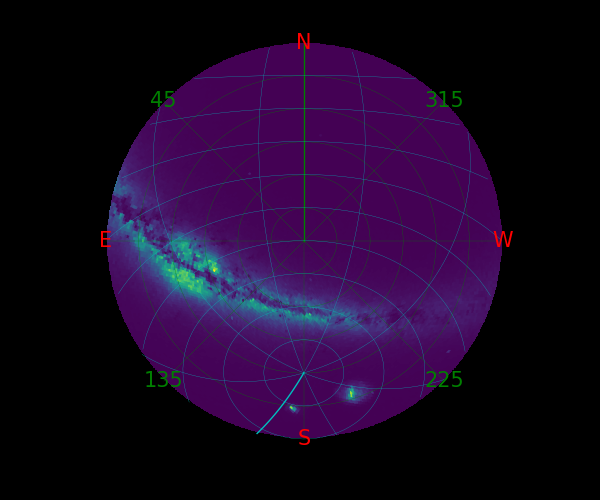

In [10]:
# Check the sky at the end of the schedule to make sure galaxy/moon are still out of the way.
peekSky.peek_sky(night1_schedule['obstime'][-1])

   alt      America/Santiago                     UTC                      PT

sunset
     0   2024-06-26 17:47:50     2024-06-26 21:47:50     2024-06-26 14:47:50
    -6   2024-06-26 18:18:35     2024-06-26 22:18:35     2024-06-26 15:18:35
   -12   2024-06-26 18:48:32     2024-06-26 22:48:32     2024-06-26 15:48:32
   -18   2024-06-26 19:17:51     2024-06-26 23:17:51     2024-06-26 16:17:51

sunrise
     0   2024-06-27 07:44:20     2024-06-27 11:44:20     2024-06-27 04:44:20
    -6   2024-06-27 07:13:35     2024-06-27 11:13:35     2024-06-27 04:13:35
   -12   2024-06-27 06:43:39     2024-06-27 10:43:39     2024-06-27 03:43:39
   -18   2024-06-27 06:14:21     2024-06-27 10:14:21     2024-06-27 03:14:21

moonrise
     0   2024-06-26 23:01:55     2024-06-27 03:01:55     2024-06-26 20:01:55

moonset
     0   2024-06-27 11:52:45     2024-06-27 15:52:45     2024-06-27 08:52:45


(<Figure size 600x500 with 1 Axes>, <Axes: >)

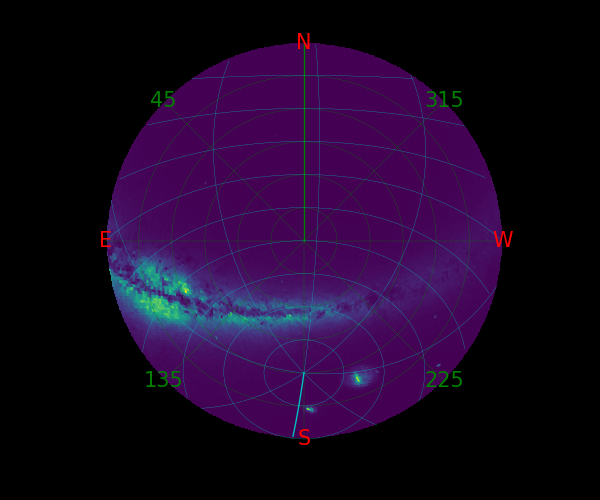

In [11]:
# Night 2
night2 = almanac("2024-06-26", verbose=True)
# Check sky
peekSky.peek_sky(night2['sunset'][-12])

In [12]:
# Sky is basically the same.  Continue with more focus sweeps and sensitivity measurements.
# Let's try a different band.
# And a different rotator position for the focus sweeps.

# Focus sweep dz
nobs = 9
mask = [False]+[True]*(nobs-1)  # Set alt/az/rtp in first obs, then track afterwards.
alt = Masked([75.0]*nobs*u.deg, mask=mask)
az = Masked([9.0]*nobs*u.deg, mask=mask)  # Will end up tracking from ~9 to -9 degrees
rtp = Masked([-45.0]*nobs*u.deg, mask=mask)
cam_shift_dz = np.linspace(-150, 150, nobs)*u.micron

night2_blocks = {}
night2_blocks['sweep_cam_dz'] = Block(
    az=az,
    alt=alt,
    rtp=rtp,
    cam_shift_dz=cam_shift_dz,
    n=nobs,
    band="r",
    name="sweep_cam_dz"
)

# Continue tracking.  Let's sweek cam rx and ry this time.
mask = [True]*nobs
alt = Masked([75.0]*nobs*u.deg, mask=mask)
az = Masked([1.0]*nobs*u.deg, mask=mask)
rtp = Masked([-45.0]*nobs*u.deg, mask=mask)
cam_rot_rx = np.linspace(-7.5, 7.5, nobs)*u.arcmin
night2_blocks['sweep_cam_rx'] = Block(
    az=az,
    alt=alt,
    rtp=rtp,
    cam_rot_rx=cam_rot_rx,
    n=nobs,
    band="r",
    name="sweep_cam_rx"
)
cam_rot_ry = np.linspace(-7.5, 7.5, nobs)*u.arcmin
night2_blocks['sweep_cam_ry'] = Block(
    az=az,
    alt=alt,
    rtp=rtp,
    cam_rot_ry=cam_rot_ry,
    n=nobs,
    band="r",
    name="sweep_cam_ry"
)
for block in night2_blocks.values():
    block._table.pprint_all()

 block_name  band exptime elaptime focusZ m2_shift [dz, dx, dy] m2_rot [rx, ry] cam_shift [dz, dx, dy] cam_rot [rx, ry] m1m3_bend   m2_bend    az alt   rtp 
                     s       s       mm           micron             arcsec             micron              arcsec        micron     micron   deg deg   deg 
------------ ---- ------- -------- ------ --------------------- --------------- ---------------------- ---------------- ---------- ---------- --- ---- -----
sweep_cam_dz    r    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)        (-150., 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 9.0 75.0 -45.0
sweep_cam_dz    r    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)       (-112.5, 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 ———  ———   ———
sweep_cam_dz    r    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)         (-75., 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 ———  ———   ———
sweep_cam_dz    r    30.0     45.0    0.0          (0., 0.

In [13]:
# Night 2 sensitivity.
# Stick with r-band.
# Let's do tilt degrees of freedom this time.
ntriplet = 9
mask = np.tile([False, True, True], ntriplet)  # Ratchet back every 3rd exposure, track in between.

# Rotate from -85 to 85 degrees in rtp.
rtps = np.full(3*ntriplet, np.nan)*u.deg
rtps[::3] = np.linspace(-85, 85, ntriplet)*u.deg
rtps = Masked(rtps, mask=mask)
alts = Masked(np.tile([75, np.nan, np.nan], ntriplet)*u.deg, mask=mask)
azs = Masked(np.tile([1, np.nan, np.nan], ntriplet)*u.deg, mask=mask)

night2_blocks['sens_cam_rx'] = Block(
    name="sens_cam_rx",
    n=3*ntriplet, # 10x triplets
    focusZ = np.tile([-1.5, 1.5, 0.0]*u.mm, ntriplet),  # intra/extra/focal
    cam_rot_rx = np.repeat(np.linspace(-5, 5, ntriplet), 3)*u.arcmin,
    alt=alts,
    az=azs,
    rtp=rtps,
    band="r"
)

night2_blocks['sens_cam_ry'] = Block(
    name="sens_cam_ry",
    n=3*ntriplet, # 10x triplets
    focusZ = np.tile([-1.5, 1.5, 0.0]*u.mm, ntriplet),  # intra/extra/focal
    cam_rot_ry = np.repeat(np.linspace(-5, 5, ntriplet), 3)*u.arcmin,
    alt=alts,
    az=azs,
    rtp=rtps,
    band="r"
)

# Do M2 rotation as well.
night2_blocks['sens_m2_rx'] = Block(
    name="sens_m2_rx",
    n=3*ntriplet, # 10x triplets
    focusZ = np.tile([-1.5, 1.5, 0.0]*u.mm, ntriplet),  # intra/extra/focal
    m2_rot_rx = np.repeat(np.linspace(-1.5, 1.5, ntriplet), 3)*u.arcmin,
    alt=alts,
    az=azs,
    rtp=rtps,
    band="r"
)

night2_blocks['sens_m2_ry'] = Block(
    name="sens_m2_ry",
    n=3*ntriplet, # 10x triplets
    focusZ = np.tile([-1.5, 1.5, 0.0]*u.mm, ntriplet),  # intra/extra/focal
    m2_rot_ry = np.repeat(np.linspace(-1.5, 1.5, ntriplet), 3)*u.arcmin,
    alt=alts,
    az=azs,
    rtp=rtps,
    band="r"
)

In [14]:
night2_schedule = schedule_blocks(night2_blocks, night2['sunset'][-12])

In [15]:
night2_schedule.pprint_all()

 block_name  band exptime elaptime focusZ m2_shift [dz, dx, dy] m2_rot [rx, ry] cam_shift [dz, dx, dy] cam_rot [rx, ry] m1m3_bend   m2_bend            az                alt                rtp                 ra                 dec                rsp                 obstime                   ha                   q         
                     s       s       mm           micron             arcsec             micron              arcsec        micron     micron           deg                deg                deg                deg                 deg                deg                                       hourangle               deg        
------------ ---- ------- -------- ------ --------------------- --------------- ---------------------- ---------------- ---------- ---------- ------------------- ----------------- ------------------- ------------------ ------------------- ------------------ ----------------------- ---------------------- ------------------
sweep_cam_dz    r    30.0   

   alt      America/Santiago                     UTC                      PT

sunset
     0   2024-06-27 17:48:10     2024-06-27 21:48:10     2024-06-27 14:48:10
    -6   2024-06-27 18:18:55     2024-06-27 22:18:55     2024-06-27 15:18:55
   -12   2024-06-27 18:48:50     2024-06-27 22:48:50     2024-06-27 15:48:50
   -18   2024-06-27 19:18:09     2024-06-27 23:18:09     2024-06-27 16:18:09

sunrise
     0   2024-06-28 07:44:24     2024-06-28 11:44:24     2024-06-28 04:44:24
    -6   2024-06-28 07:13:40     2024-06-28 11:13:40     2024-06-28 04:13:40
   -12   2024-06-28 06:43:45     2024-06-28 10:43:45     2024-06-28 03:43:45
   -18   2024-06-28 06:14:27     2024-06-28 10:14:27     2024-06-28 03:14:27

moonrise
     0   2024-06-28 00:07:00     2024-06-28 04:07:00     2024-06-27 21:07:00

moonset
     0   2024-06-27 11:52:45     2024-06-27 15:52:45     2024-06-27 08:52:45


(<Figure size 600x500 with 1 Axes>, <Axes: >)

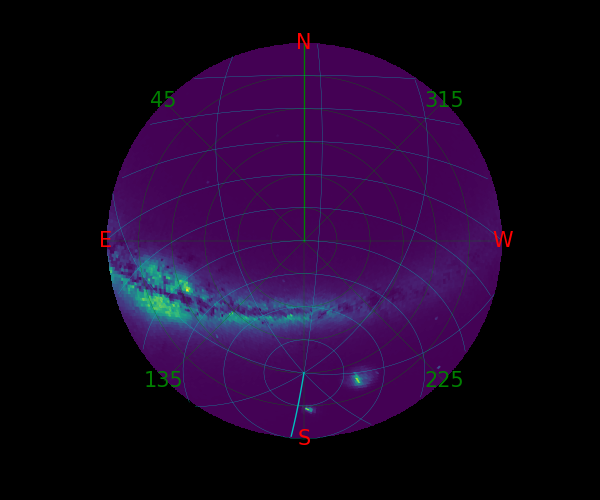

In [16]:
# Night 3 schedule
night3 = almanac("2024-06-27", verbose=True)
# Check sky
peekSky.peek_sky(night3['sunset'][-12])

In [17]:
# Sky is basically the same.  Continue with more focus sweeps and sensitivity measurements.
# Let's go back to i-band.
# And a different rotator position for the focus sweeps.

# Focus sweep dz
nobs = 9
mask = [False]+[True]*(nobs-1)  # Set alt/az/rtp in first obs, then track afterwards.
alt = Masked([75.0]*nobs*u.deg, mask=mask)
az = Masked([9.0]*nobs*u.deg, mask=mask)  # Will end up tracking from ~9 to -9 degrees
rtp = Masked([45.0]*nobs*u.deg, mask=mask)
cam_shift_dz = np.linspace(-150, 150, nobs)*u.micron

night3_blocks = {}
night3_blocks['sweep_cam_dz'] = Block(
    az=az,
    alt=alt,
    rtp=rtp,
    cam_shift_dz=cam_shift_dz,
    n=nobs,
    band="i",
    name="sweep_cam_dz"
)

# Continue tracking.  Let's sweep M2 rx and ry this time.
mask = [True]*nobs
alt = Masked([75.0]*nobs*u.deg, mask=mask)
az = Masked([1.0]*nobs*u.deg, mask=mask)
rtp = Masked([45.0]*nobs*u.deg, mask=mask)
m2_rot_rx = np.linspace(-2, 2, nobs)*u.arcmin
night3_blocks['sweep_m2_rx'] = Block(
    az=az,
    alt=alt,
    rtp=rtp,
    m2_rot_rx=m2_rot_rx,
    n=nobs,
    band="i",
    name="sweep_m2_rx"
)

m2_rot_ry = np.linspace(-2, 2, nobs)*u.arcmin
night3_blocks['sweep_m2_ry'] = Block(
    az=az,
    alt=alt,
    rtp=rtp,
    m2_rot_ry=m2_rot_ry,
    n=nobs,
    band="i",
    name="sweep_m2_ry"
)
for block in night3_blocks.values():
    block._table.pprint_all()

 block_name  band exptime elaptime focusZ m2_shift [dz, dx, dy] m2_rot [rx, ry] cam_shift [dz, dx, dy] cam_rot [rx, ry] m1m3_bend   m2_bend    az alt  rtp 
                     s       s       mm           micron             arcsec             micron              arcsec        micron     micron   deg deg  deg 
------------ ---- ------- -------- ------ --------------------- --------------- ---------------------- ---------------- ---------- ---------- --- ---- ----
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)        (-150., 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 9.0 75.0 45.0
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)       (-112.5, 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 ———  ———  ———
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.)        (0., 0.)         (-75., 0., 0.)         (0., 0.) 0.0 .. 0.0 0.0 .. 0.0 ———  ———  ———
sweep_cam_dz    i    30.0     45.0    0.0          (0., 0., 0.) 

In [18]:
# Night 3 sensitivity.
# Stick with i-band.
# Let's try some M1M3 bending modes this time.
ntriplet = 9
mask = np.tile([False, True, True], ntriplet)  # Ratchet back every 3rd exposure, track in between.

# Rotate from -85 to 85 degrees in rtp.
rtps = np.full(3*ntriplet, np.nan)*u.deg
rtps[::3] = np.linspace(-85, 85, ntriplet)*u.deg
rtps = Masked(rtps, mask=mask)
alts = Masked(np.tile([75, np.nan, np.nan], ntriplet)*u.deg, mask=mask)
azs = Masked(np.tile([1, np.nan, np.nan], ntriplet)*u.deg, mask=mask)

night3_blocks['sens_m1m3_b1'] = Block(
    name="sens_m1m3_b1",
    n=3*ntriplet, # 10x triplets
    focusZ = np.tile([-1.5, 1.5, 0.0]*u.mm, ntriplet),  # intra/extra/focal
    m1m3_b1 = np.repeat(np.linspace(-1.0, 1.0, ntriplet), 3)*u.micron,
    alt=alts,
    az=azs,
    rtp=rtps,
    band="i"
)

night3_blocks['sens_m1m3_b4'] = Block(
    name="sens_m1m3_b4",
    n=3*ntriplet, # 10x triplets
    focusZ = np.tile([-1.5, 1.5, 0.0]*u.mm, ntriplet),  # intra/extra/focal
    m1m3_b4 = np.repeat(np.linspace(-1.0, 1.0, ntriplet), 3)*u.micron,
    alt=alts,
    az=azs,
    rtp=rtps,
    band="i"
)

In [19]:
night3_schedule = schedule_blocks(night3_blocks, night3['sunset'][-12])

In [20]:
night3_schedule.pprint_all()

 block_name  band exptime elaptime focusZ m2_shift [dz, dx, dy] m2_rot [rx, ry] cam_shift [dz, dx, dy] cam_rot [rx, ry]  m1m3_bend    m2_bend            az                alt                rtp                 ra                 dec                rsp                 obstime                   ha                  q         
                     s       s       mm           micron             arcsec             micron              arcsec         micron      micron           deg                deg                deg                deg                 deg                deg                                       hourangle              deg        
------------ ---- ------- -------- ------ --------------------- --------------- ---------------------- ---------------- ------------ ---------- ------------------- ----------------- ------------------- ------------------ ------------------- ------------------ ----------------------- --------------------- ------------------
sweep_cam_dz    i    30.0

In [21]:
print(
    len(night1_schedule),
    len(night2_schedule),
    len(night3_schedule),
)

108 135 81


In [22]:
# Add some indices to each night.
night1_schedule['dayobs'] = 20240625
night2_schedule['dayobs'] = 20240626
night3_schedule['dayobs'] = 20240627

night1_schedule['seqnum'] = np.arange(1, len(night1_schedule)+1)
night2_schedule['seqnum'] = np.arange(1, len(night2_schedule)+1)
night3_schedule['seqnum'] = np.arange(1, len(night3_schedule)+1)

# And TAI MJD for easier galsim config parsing.
night1_schedule['mjd'] = night1_schedule['obstime'].tai.mjd
night2_schedule['mjd'] = night2_schedule['obstime'].tai.mjd
night3_schedule['mjd'] = night3_schedule['obstime'].tai.mjd

In [23]:
from astropy.table import vstack
schedule = vstack([night1_schedule, night2_schedule, night3_schedule])

In [24]:
# Let's reorder some of the columns.
cols = schedule.colnames
new_cols = ['dayobs', 'seqnum', 'block_name', 'band', 'mjd', 'ra', 'dec', 'rsp', 'az', 'alt', 'rtp', 'ha', 'q']
for col in cols:
    if col not in new_cols:
        new_cols.append(col)
new_cols
schedule = schedule[new_cols]

In [25]:
schedule.write("OR4_AOS_schedule.ecsv", overwrite=True)